# Neural networks for tabular data

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sb

In [5]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from pathlib import Path

In [6]:
import xgboost as xgb
from sklearn.metrics import r2_score

## Regression dataset

`pip install pmlb` <br>
To install A Python wrapper for the Penn Machine Learning Benchmark data repository.

In [7]:
PATH = Path("/data2/yinterian/pmlb/")

In [8]:
from pmlb import fetch_data, regression_dataset_names

In [9]:
# filtering datasets with enough data
list_dataset = {}

for dataset in regression_dataset_names:
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    if X.shape[0] >= 5000:
        list_dataset[dataset] = (X.shape[0],X.shape[1]) 

In [10]:
list_dataset

{'1191_BNG_pbc': (1000000, 18),
 '1193_BNG_lowbwt': (31104, 9),
 '1196_BNG_pharynx': (1000000, 10),
 '1199_BNG_echoMonths': (17496, 9),
 '1201_BNG_breastTumor': (116640, 9),
 '1203_BNG_pwLinear': (177147, 10),
 '1595_poker': (1025010, 10),
 '197_cpu_act': (8192, 21),
 '201_pol': (15000, 48),
 '215_2dplanes': (40768, 10),
 '218_house_8L': (22784, 8),
 '225_puma8NH': (8192, 8),
 '227_cpu_small': (8192, 12),
 '294_satellite_image': (6435, 36),
 '344_mv': (40768, 10),
 '503_wind': (6574, 14),
 '537_houses': (20640, 8),
 '562_cpu_small': (8192, 12),
 '564_fried': (40768, 10),
 '573_cpu_act': (8192, 21),
 '574_house_16H': (22784, 16)}

In [11]:
datasets = list(list_dataset.keys())

In [15]:
dataset = datasets[1]
dataset

'1193_BNG_lowbwt'

## Split train / valid / test

In [16]:
def split_dataset(dataset, seed=1):
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=seed)
    valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.5, random_state=seed)
    return train_X, valid_X, test_X, train_y, valid_y, test_y

In [17]:
train_X, valid_X, test_X, train_y, valid_y, test_y = split_dataset(dataset)

## Baseline Random Forest scores 

In [18]:
def RF_scores(train_X, valid_X, train_y, valid_y):
    
    D = train_X.shape[1]
    max_features = np.unique([int(x*D + 1) for x in np.linspace(0.01, 0.99, num = 5)])
    grid = {'max_features': max_features}
    rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs = 10)
    rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, verbose=2,
                         n_jobs = 5)
    
    rf_cv.fit(train_X, train_y)
    return rf_cv.score(valid_X, valid_y)

In [19]:
# baseline RF score
# takes a few minutes
RF_scores(train_X, valid_X, train_y, valid_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:   38.7s finished


0.5717712590938855

## Baseline Gradient boosting scores

In [26]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.01, 'colsample_bytree': 0.5, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(valid_X, label=valid_y)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [27]:
gbm = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=200)

[0]	train-rmse:2999.54	valid-rmse:2996.33
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:634.538	valid-rmse:625.513
[400]	train-rmse:464.522	valid-rmse:458.824
[600]	train-rmse:453.205	valid-rmse:449.94
[800]	train-rmse:450.123	valid-rmse:448.054
[999]	train-rmse:448.36	valid-rmse:447.051


In [28]:
y_pred = gbm.predict(dvalid)
r2_score(valid_y, y_pred)

0.6071586692442561

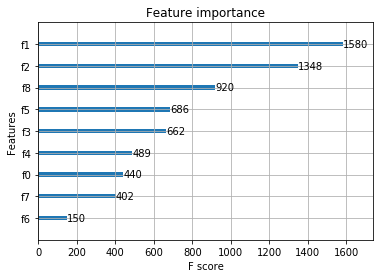

In [29]:
xgb.plot_importance(gbm)

## Ecoding features

In [33]:
def encode_cat_variables(x, help_dict = None, N = 100):
    """Encodes a categorical variable
    
    The index 0 is left for values not in training
    """
    uniqs = np.unique(x)
    if help_dict is None: help_dict = {v:k+1 for k, v in enumerate(uniqs)}
    levels = len(help_dict.keys()) + 1
    x_t = np.array([help_dict.get(x_i, 0) for x_i in x])
    return x_t, help_dict, levels

In [32]:
def split_num_cat_columns(X):
    """Splits variables into: categorical and numeric
    
    Heuristic to determine which variable is categorical.
    Returns:
       cat_ind: array of indices for categorical variables
       cont_ind: array of indices for continous variables
    """
    cat_ind = []
    cont_ind = []
    for i in range(X.shape[1]):
        uniqs_len = len(np.unique(X[:,i]))
        fraction = uniqs_len/X.shape[0]
        if uniqs_len == 2 or fraction > 0.01: # you can change this rule
            cont_ind.append(i)
        else:
            cat_ind.append(i)
    return cat_ind, cont_ind   

In [34]:
def transform_dataset(train_X, valid_X, test_X):
    
    cat_ind, cont_ind = split_num_cat_columns(train_X)
    
    train_X_cat = train_X[:, cat_ind]
    train_X_cont = train_X[:, cont_ind]
    
    valid_X_cat = valid_X[:, cat_ind]
    valid_X_cont = valid_X[:, cont_ind]
    
    test_X_cat = test_X[:, cat_ind]
    test_X_cont = test_X[:, cont_ind]
    
    scaler = StandardScaler()
    train_X_cont = scaler.fit_transform(train_X_cont)
    valid_X_cont = scaler.transform(valid_X_cont)
    test_X_cont = scaler.transform(test_X_cont)
    
    level_arr = [0]*train_X_cat.shape[1]
    for i in range(train_X_cat.shape[1]):
        x, help_arr, levels = encode_cat_variables(train_X_cat[:,i])
        train_X_cat[:,i] = x
        level_arr[i] = levels
        x, _, _ = encode_cat_variables(valid_X_cat[:,i], help_arr)
        valid_X_cat[:,i] = x
        x, _, _ = encode_cat_variables(test_X_cat[:,i], help_arr)
        test_X_cat[:,i] = x
    return (train_X_cat, train_X_cont, valid_X_cat, valid_X_cont, test_X_cat, test_X_cont), level_arr

## Dataset and dataloader

In [35]:
dataset

'1193_BNG_lowbwt'

In [36]:
train_X, valid_X, test_X, train_y, valid_y, test_y = split_dataset(dataset)

In [37]:
# split between categorical and continous variables
cat_ind, cont_ind  = split_num_cat_columns(train_X)
cat_ind, cont_ind

([3, 5, 8], [0, 1, 2, 4, 6, 7])

In [38]:
# transforms variables
(train_X_cat, train_X_cont, valid_X_cat, valid_X_cont, test_X_cat, test_X_cont), level_arr \
= transform_dataset(train_X, valid_X, test_X)

In [40]:
# here are the number of unique values of every categorical variable
level_arr

[4, 5, 7]

In [41]:
class TabularDataSet(Dataset):
    def __init__(self, X_cat, X_cont, Y):
        self.X_cat = X_cat
        self.X_cont = X_cont
        self.Y = Y

    def __getitem__(self, index):
        return self.X_cat[index], self.X_cont[index], self.Y[index]

    def __len__(self):
        return len(self.Y)

In [42]:
batch_size = 5
train_ds = TabularDataSet(train_X_cat, train_X_cont, train_y)
valid_ds = TabularDataSet(valid_X_cat, valid_X_cont, valid_y)
test_ds = TabularDataSet(test_X_cat, test_X_cont, valid_y)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [43]:
x1, x2, y = next(iter(train_dl))

In [44]:
x1

tensor([[1., 2., 1.],
        [3., 1., 1.],
        [3., 1., 4.],
        [3., 1., 4.],
        [3., 1., 3.]], dtype=torch.float64)

In [45]:
x2

tensor([[ 1.4856, -1.0958, -0.0276, -0.8243, -0.2766, -2.2931],
        [ 1.4856,  0.2633, -1.5297,  1.2132, -0.2766,  0.4361],
        [ 1.4856,  0.1341,  0.1412,  1.2132,  3.6158,  0.4361],
        [-0.6731,  0.8056, -0.5703,  1.2132, -0.2766,  0.4361],
        [-0.6731, -0.6626,  2.8158,  1.2132, -0.2766, -2.2931]],
       dtype=torch.float64)

## Training functions

In [46]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [47]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

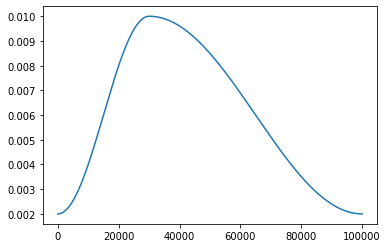

In [48]:
N = 100000
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [49]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [50]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        y = y.unsqueeze(1).float()
        out = model(x1.long().cuda(), x2.float().cuda())
        loss = F.mse_loss(out, y.cuda())
        sum_loss += batch*(loss.item())
        total += batch
        y_hat.append(out.detach().cpu().numpy())
        ys.append(y)
    
    y_hat = np.vstack(y_hat)
    ys = np.vstack(ys)
    r2 = metrics.r2_score(ys, y_hat)
    return sum_loss/total, r2

In [51]:
def train_model(model, train_dl, valid_dl, optimizer, max_lr=0.05, epochs=100):
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    idx = 0
    best_val_r2 = 0
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for t in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x1, x2, y in train_dl:
            update_optimizer(optimizer, lrs[idx])
            x1 = x1.cuda().long()
            x2 = x2.cuda().float()
            y = y.unsqueeze(1).cuda().float()
            y_hat = model(x1, x2)
            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*y.size(0)
            total += y.size(0)
            idx +=1
            pbar.update()
        val_loss, val_r2 = val_metrics(model, valid_dl)
        print("\tTrain loss: {:.3f} \t Valid loss: {:.3f} \t Valid R2:  {:.3f}".format(
            total_loss/total, val_loss, val_r2))  
        if best_val_r2 < val_r2:
            best_val_r2 = val_r2
            path = "{0}/models/model_{1}_acc_{2:.0f}.pth".format(PATH, dataset, 100*val_r2) 
            save_model(model, path)
            print(path)
            
    print("Best valid r2: {:.3f}".format(best_val_r2))
    return best_val_r2

## Neural network model 

In [52]:
class TabularNet(nn.Module):
    def __init__(self, num_cont, num_cat, level_arr, hidden_dim=50):
        super(TabularNet, self).__init__()
        in_dim = num_cont + 2*num_cat
        self.embs = nn.ModuleList([nn.Embedding(level_arr[i], 2) for i in range(len(level_arr))])
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
                                  
    def forward(self, x_cat, x_cont):
        x_cat = [self.embs[i](x_cat[:,i]) for i in range(x_cat.size(1))]
        x_cat = torch.cat(x_cat, dim=1)
        x_cat = self.dropout(x_cat)
        x = torch.cat([ x_cont, x_cat], dim=1)
        x = self.bn(F.relu(self.linear1(x)))
        return self.linear2(x)

In [61]:
class TabularNet(nn.Module):
    def __init__(self, num_cont, num_cat, level_arr, hidden_dim=1000, hidden_dim2=1000):
        super(TabularNet, self).__init__()
        in_dim = num_cont + 2*num_cat
        self.embs = nn.ModuleList([nn.Embedding(level_arr[i], 2) for i in range(len(level_arr))])
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(0.2)
                                  
    def forward(self, x_cat, x_cont):
        x_cat = [self.embs[i](x_cat[:,i]) for i in range(x_cat.size(1))]
        x_cat = torch.cat(x_cat, dim=1)
        x_cat = self.dropout(x_cat)
        x = torch.cat([x_cont, x_cat], dim=1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = self.bn2(F.relu(self.linear2(x)))
        return self.linear3(x)

## Training model

In [62]:
batch_size = 100000

num_cont = train_X_cont.shape[1]
num_cat = train_X_cat.shape[1]

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [66]:
model = TabularNet(num_cont, num_cat, level_arr).cuda()

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
best_val = train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 9177997.000 	 Valid loss: 9154457.000 	 Valid R2:  -16.994
	Train loss: 9163736.000 	 Valid loss: 9148991.000 	 Valid R2:  -16.984
	Train loss: 9153421.000 	 Valid loss: 9128220.000 	 Valid R2:  -16.943
	Train loss: 9141191.000 	 Valid loss: 9094178.000 	 Valid R2:  -16.876
	Train loss: 9126398.000 	 Valid loss: 9038165.000 	 Valid R2:  -16.766
	Train loss: 9108826.000 	 Valid loss: 8945214.000 	 Valid R2:  -16.583
	Train loss: 9087690.000 	 Valid loss: 8852170.000 	 Valid R2:  -16.400
	Train loss: 9062515.000 	 Valid loss: 8741953.000 	 Valid R2:  -16.183
	Train loss: 9032220.000 	 Valid loss: 8634086.000 	 Valid R2:  -15.971
	Train loss: 8995769.000 	 Valid loss: 8533773.000 	 Valid R2:  -15.774
	Train loss: 8951964.000 	 Valid loss: 8342532.000 	 Valid R2:  -15.398
	Train loss: 8899377.000 	 Valid loss: 8172606.500 	 Valid R2:  -15.064
	Train loss: 8836225.000 	 Valid loss: 8056035.000 	 Valid R2:  -14.835
	Train loss: 8761352.000 	 Valid loss: 7873381.000 	 Valid R2:  

	Train loss: 201416.875 	 Valid loss: 199427.531 	 Valid R2:  0.608
/data2/yinterian/pmlb/models/model_1193_BNG_lowbwt_acc_61.pth
Best valid r2: 0.608


In [68]:
best_val

0.6079983696878916

## Lab
* Find a dataset (from pmlb) from with just categorical variables. Modify some of the code to make it work in this case.
* Find a dataset (from pmlb) with all continous variables. Modifiy teh code to make it work in this case as well.